In [1]:
# -------------------- Imports --------------------
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
import os
from torchmetrics import JaccardIndex
import albumentations as A
from albumentations.pytorch import ToTensorV2 
from torchvision import transforms
import torch.nn as nn
import time

In [2]:
# -------------------- Config --------------------
LEARNING_RATE = 3e-5
SPLIT = 0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 10
NUM_WORKERS = 4
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
PIN_MEMORY = True
TRAIN_IMG_DIR = '/kaggle/input/ultrasound-nerve-segmentation/image'
TRAIN_MASK_DIR = '/kaggle/input/ultrasound-nerve-segmentation/mask'
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# -------------------- UNet Architecture --------------------
def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    ).to(DEVICE)


def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):
    if srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape:
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up_conv_4 = double_conv(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, image):
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        return self.out(x).to(DEVICE)

In [4]:
# -------------------- UNet++ Architecture --------------------
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes=1, input_channels=3, deep_supervision=False):
        super().__init__()
        
        nb_filter = [32, 64, 128, 256, 512]
        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            output = self.final(x0_4)
            return output

In [5]:
# -------------------- Dataset --------------------
class UltrasoundDataset(Dataset):
    def __init__(self, images, image_dir, mask_dir, transform=None, train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".tif", "_mask.tif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        return {"image": image, "mask": mask}

In [6]:
# -------------------- Transformations --------------------
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=[0.0]*3, std=[1.0]*3, max_pixel_value=255.0),
    ToTensorV2()
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Normalize(mean=[0.0]*3, std=[1.0]*3, max_pixel_value=255.0),
    ToTensorV2()
])

In [7]:
# -------------------- Train/Validation Split --------------------
def train_test_split(images, splitSize):
    val_len = int(splitSize * len(images))
    return images[:-val_len], images[-val_len:]

images = os.listdir(TRAIN_IMG_DIR)
train_images_path, val_images_path = train_test_split(images, SPLIT)
train_data = UltrasoundDataset(train_images_path, TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_transform, True)
valid_data = UltrasoundDataset(val_images_path, TRAIN_IMG_DIR, TRAIN_MASK_DIR, validation_transform, True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# -------------------- Fixed Training & Validation Functions --------------------
def fit(model, dataloader, data, optimizer, criterion, model_name="Model"):
    print(f'-------------Training {model_name}---------------')
    model.train()
    train_loss = 0.0
    for _, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        image, mask = data["image"].to(DEVICE), data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        
        # Handle UNet++ deep supervision or regular output
        if isinstance(outputs, list):
            # Deep supervision - use the final output
            outputs = outputs[-1]
        
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(dataloader)

def validate(model, dataloader, data, criterion, model_name="Model"):
    print(f"\n--------Validating {model_name}---------\n")
    model.eval()
    # Initialize metric and move to device
    metric = JaccardIndex(task='binary').to(DEVICE)
    val_loss, dice = 0.0, 0.0
    total_samples = 0
    
    with torch.no_grad():
        for _, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image, mask = data["image"].to(DEVICE), data["mask"].to(DEVICE)
            outputs = model(image)
            
            # Handle UNet++ deep supervision or regular output
            if isinstance(outputs, list):
                outputs = outputs[-1]
                
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, mask)
            val_loss += loss.item()
            probs = torch.sigmoid(outputs)
            
            # Calculate Dice for each sample in batch
            for k in range(mask.shape[0]):
                # Keep tensors on GPU for metric calculation
                dice_score = metric(probs[k], mask[k].int())
                dice += dice_score.item()
                total_samples += 1
    
    return val_loss / len(dataloader), dice / total_samples

In [9]:
# -------------------- Model Training Function --------------------
def train_model(model, model_name, epochs=EPOCHS, save_path=None):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    
    train_losses = []
    val_losses = []
    dice_scores = []
    
    best_dice = 0.0
    
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training
        train_loss = fit(model, train_loader, train_data, optimizer, criterion, model_name)
        
        # Validation
        val_loss, dice_coef = validate(model, valid_loader, valid_data, criterion, model_name)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        dice_scores.append(dice_coef)
        
        epoch_time = time.time() - start_time
        
        print(f"Epoch [{epoch+1}/{epochs}] - Time: {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Dice: {dice_coef:.4f}")
        
        # Save best model
        if dice_coef > best_dice:
            best_dice = dice_coef
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"New best model saved! Dice: {best_dice:.4f}")
        
        print("-" * 60)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'dice_scores': dice_scores,
        'best_dice': best_dice
    }

In [10]:
# -------------------- Model Setup and Training --------------------
print("Initializing models...")

# UNet Model
unet_model = UNet().to(DEVICE)
print(f"UNet parameters: {sum(p.numel() for p in unet_model.parameters()):,}")

# UNet++ Model
unetpp_model = UNetPlusPlus(num_classes=1, input_channels=3, deep_supervision=False).to(DEVICE)
print(f"UNet++ parameters: {sum(p.numel() for p in unetpp_model.parameters()):,}")

# Load pre-trained UNet if available
try:
    unet_model.load_state_dict(torch.load('/kaggle/input/unet-ultra-pt/UNET_ultra.pt', map_location=DEVICE))
    print("Loaded pre-trained UNet model")
except:
    print("No pre-trained UNet model found, training from scratch")

# Train models (uncomment to train)
print("Training UNet...")
unet_results = train_model(unet_model, "UNet", epochs=EPOCHS, save_path="UNET_ultra_new.pt")

print("Training UNet++...")
unetpp_results = train_model(unetpp_model, "UNet++", epochs=EPOCHS, save_path="UNETPlusPlus_ultra.pt")

Initializing models...
UNet parameters: 31,043,521
UNet++ parameters: 9,163,329
Loaded pre-trained UNet model
Training UNet...

Training UNet
-------------Training UNet---------------


100%|██████████| 282/282 [02:16<00:00,  2.06it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:25<00:00,  2.78it/s]


Epoch [1/10] - Time: 162.38s
Train Loss: 0.0343 | Val Loss: 0.0329 | Dice: 0.1508
New best model saved! Dice: 0.1508
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:37<00:00,  2.89it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:14<00:00,  4.80it/s]


Epoch [2/10] - Time: 112.52s
Train Loss: 0.0293 | Val Loss: 0.0292 | Dice: 0.1816
New best model saved! Dice: 0.1816
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:37<00:00,  2.90it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:14<00:00,  4.78it/s]


Epoch [3/10] - Time: 112.17s
Train Loss: 0.0272 | Val Loss: 0.0273 | Dice: 0.2020
New best model saved! Dice: 0.2020
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:37<00:00,  2.89it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:14<00:00,  4.82it/s]


Epoch [4/10] - Time: 112.21s
Train Loss: 0.0257 | Val Loss: 0.0284 | Dice: 0.1347
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:39<00:00,  2.84it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:14<00:00,  4.82it/s]


Epoch [5/10] - Time: 113.93s
Train Loss: 0.0249 | Val Loss: 0.0271 | Dice: 0.2243
New best model saved! Dice: 0.2243
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:39<00:00,  2.83it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:14<00:00,  4.91it/s]


Epoch [6/10] - Time: 114.16s
Train Loss: 0.0244 | Val Loss: 0.0253 | Dice: 0.1877
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:37<00:00,  2.90it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:14<00:00,  4.92it/s]


Epoch [7/10] - Time: 111.82s
Train Loss: 0.0239 | Val Loss: 0.0252 | Dice: 0.1776
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:37<00:00,  2.89it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:14<00:00,  4.82it/s]


Epoch [8/10] - Time: 112.16s
Train Loss: 0.0232 | Val Loss: 0.0247 | Dice: 0.2024
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:37<00:00,  2.89it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:14<00:00,  4.76it/s]


Epoch [9/10] - Time: 112.66s
Train Loss: 0.0229 | Val Loss: 0.0250 | Dice: 0.2122
------------------------------------------------------------
-------------Training UNet---------------


100%|██████████| 282/282 [01:42<00:00,  2.74it/s]



--------Validating UNet---------



100%|██████████| 71/71 [00:15<00:00,  4.67it/s]


Epoch [10/10] - Time: 118.00s
Train Loss: 0.0224 | Val Loss: 0.0244 | Dice: 0.2005
------------------------------------------------------------
Training UNet++...

Training UNet++
-------------Training UNet++---------------


100%|██████████| 282/282 [01:48<00:00,  2.60it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:15<00:00,  4.70it/s]


Epoch [1/10] - Time: 123.59s
Train Loss: 0.4964 | Val Loss: 0.4296 | Dice: 0.0966
New best model saved! Dice: 0.0966
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:47<00:00,  2.62it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:14<00:00,  4.75it/s]


Epoch [2/10] - Time: 122.40s
Train Loss: 0.4277 | Val Loss: 0.4010 | Dice: 0.1860
New best model saved! Dice: 0.1860
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:44<00:00,  2.69it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:15<00:00,  4.73it/s]


Epoch [3/10] - Time: 119.68s
Train Loss: 0.3976 | Val Loss: 0.3740 | Dice: 0.1688
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:47<00:00,  2.61it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:17<00:00,  3.99it/s]


Epoch [4/10] - Time: 125.73s
Train Loss: 0.3711 | Val Loss: 0.3514 | Dice: 0.2049
New best model saved! Dice: 0.2049
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:45<00:00,  2.68it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:14<00:00,  4.78it/s]


Epoch [5/10] - Time: 120.05s
Train Loss: 0.3467 | Val Loss: 0.3281 | Dice: 0.2011
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:45<00:00,  2.68it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:15<00:00,  4.72it/s]


Epoch [6/10] - Time: 120.22s
Train Loss: 0.3249 | Val Loss: 0.3063 | Dice: 0.2133
New best model saved! Dice: 0.2133
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:49<00:00,  2.58it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:15<00:00,  4.71it/s]


Epoch [7/10] - Time: 124.39s
Train Loss: 0.3047 | Val Loss: 0.2874 | Dice: 0.1965
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:45<00:00,  2.68it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:17<00:00,  4.11it/s]


Epoch [8/10] - Time: 122.65s
Train Loss: 0.2857 | Val Loss: 0.2667 | Dice: 0.1787
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:56<00:00,  2.42it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:18<00:00,  3.74it/s]


Epoch [9/10] - Time: 135.44s
Train Loss: 0.2677 | Val Loss: 0.2509 | Dice: 0.1971
------------------------------------------------------------
-------------Training UNet++---------------


100%|██████████| 282/282 [01:58<00:00,  2.38it/s]



--------Validating UNet++---------



100%|██████████| 71/71 [00:17<00:00,  3.98it/s]

Epoch [10/10] - Time: 136.27s
Train Loss: 0.2506 | Val Loss: 0.2373 | Dice: 0.2082
------------------------------------------------------------



Evaluating UNet

--------Validating UNet---------



100%|██████████| 71/71 [00:17<00:00,  4.11it/s]


UNet Results:
Validation Loss: 0.0244
Dice Coefficient: 0.2005

Evaluating UNet++

--------Validating UNet++---------



100%|██████████| 71/71 [00:15<00:00,  4.60it/s]


UNet++ Results:
Validation Loss: 0.2373
Dice Coefficient: 0.2082

MODEL COMPARISON
Model           Val Loss     Dice Score  
----------------------------------------
UNet            0.0244       0.2005      
UNet++          0.2373       0.2082      
----------------------------------------
 UNet++ wins by 0.0077 Dice score!
Visualizing UNet predictions...


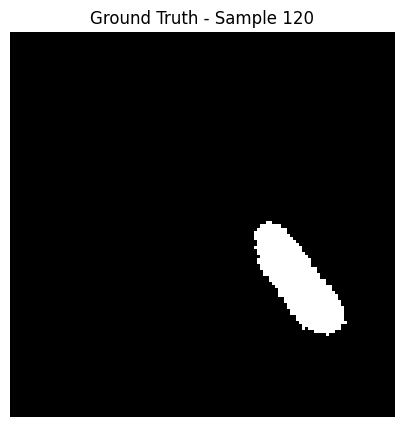

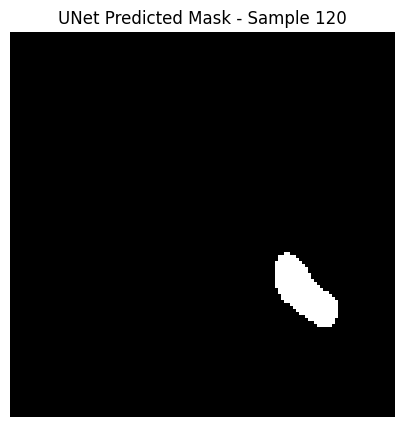

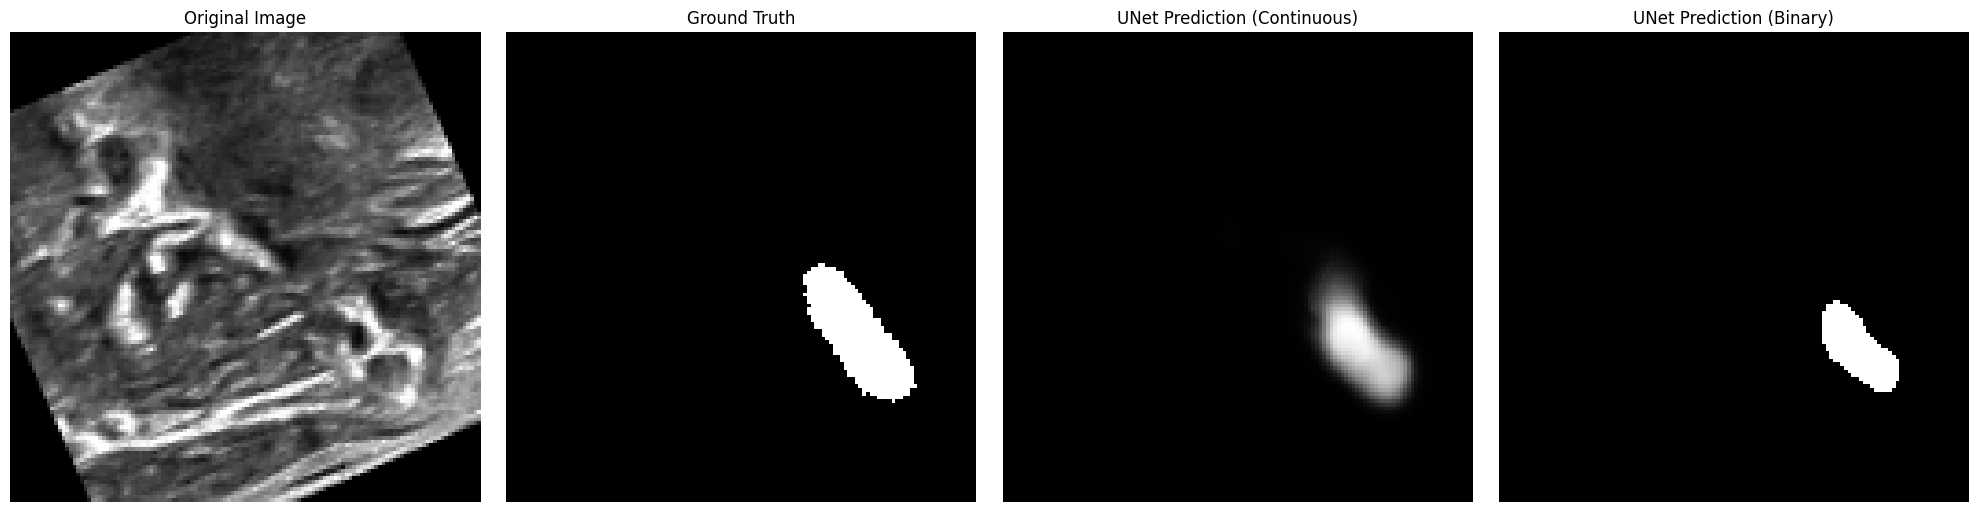

Visualizing UNet++ predictions...


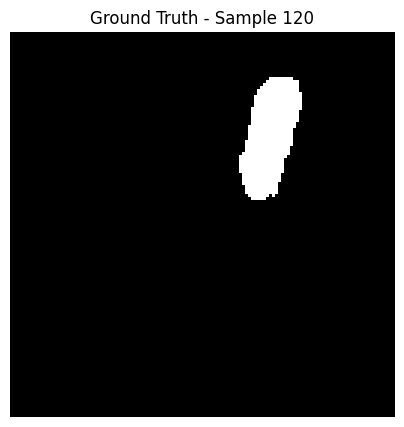

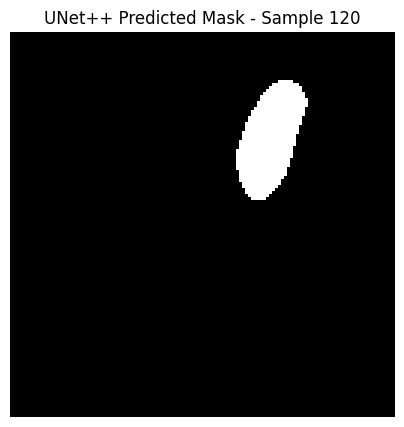

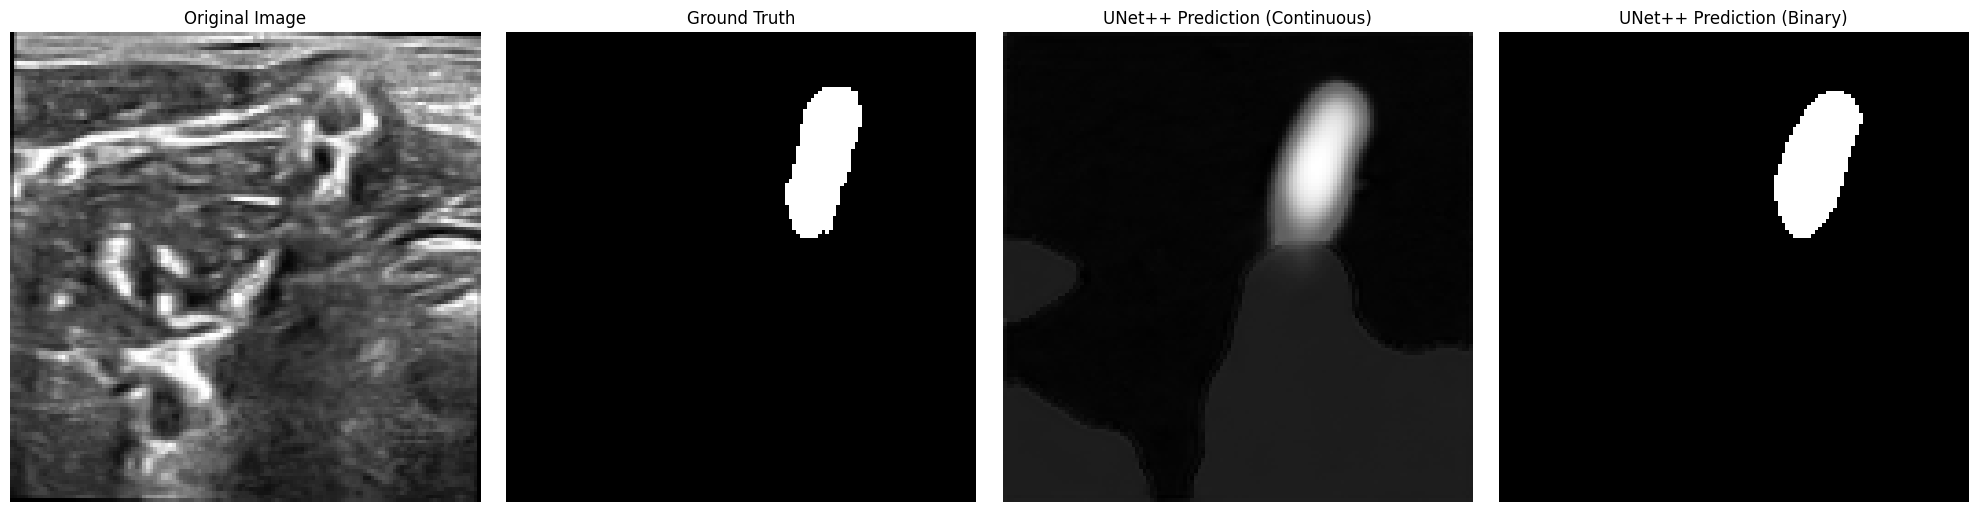

Calculating detailed metrics...


Calculating metrics for UNet: 71it [00:14,  4.82it/s]
Calculating metrics for UNet++: 71it [00:15,  4.64it/s]



Detailed Metrics Comparison:
Model           Mean Dice    Std Dice    
----------------------------------------
UNet            0.2005       0.3016      
UNet++          0.2082       0.2991      
Comparing both models side-by-side...


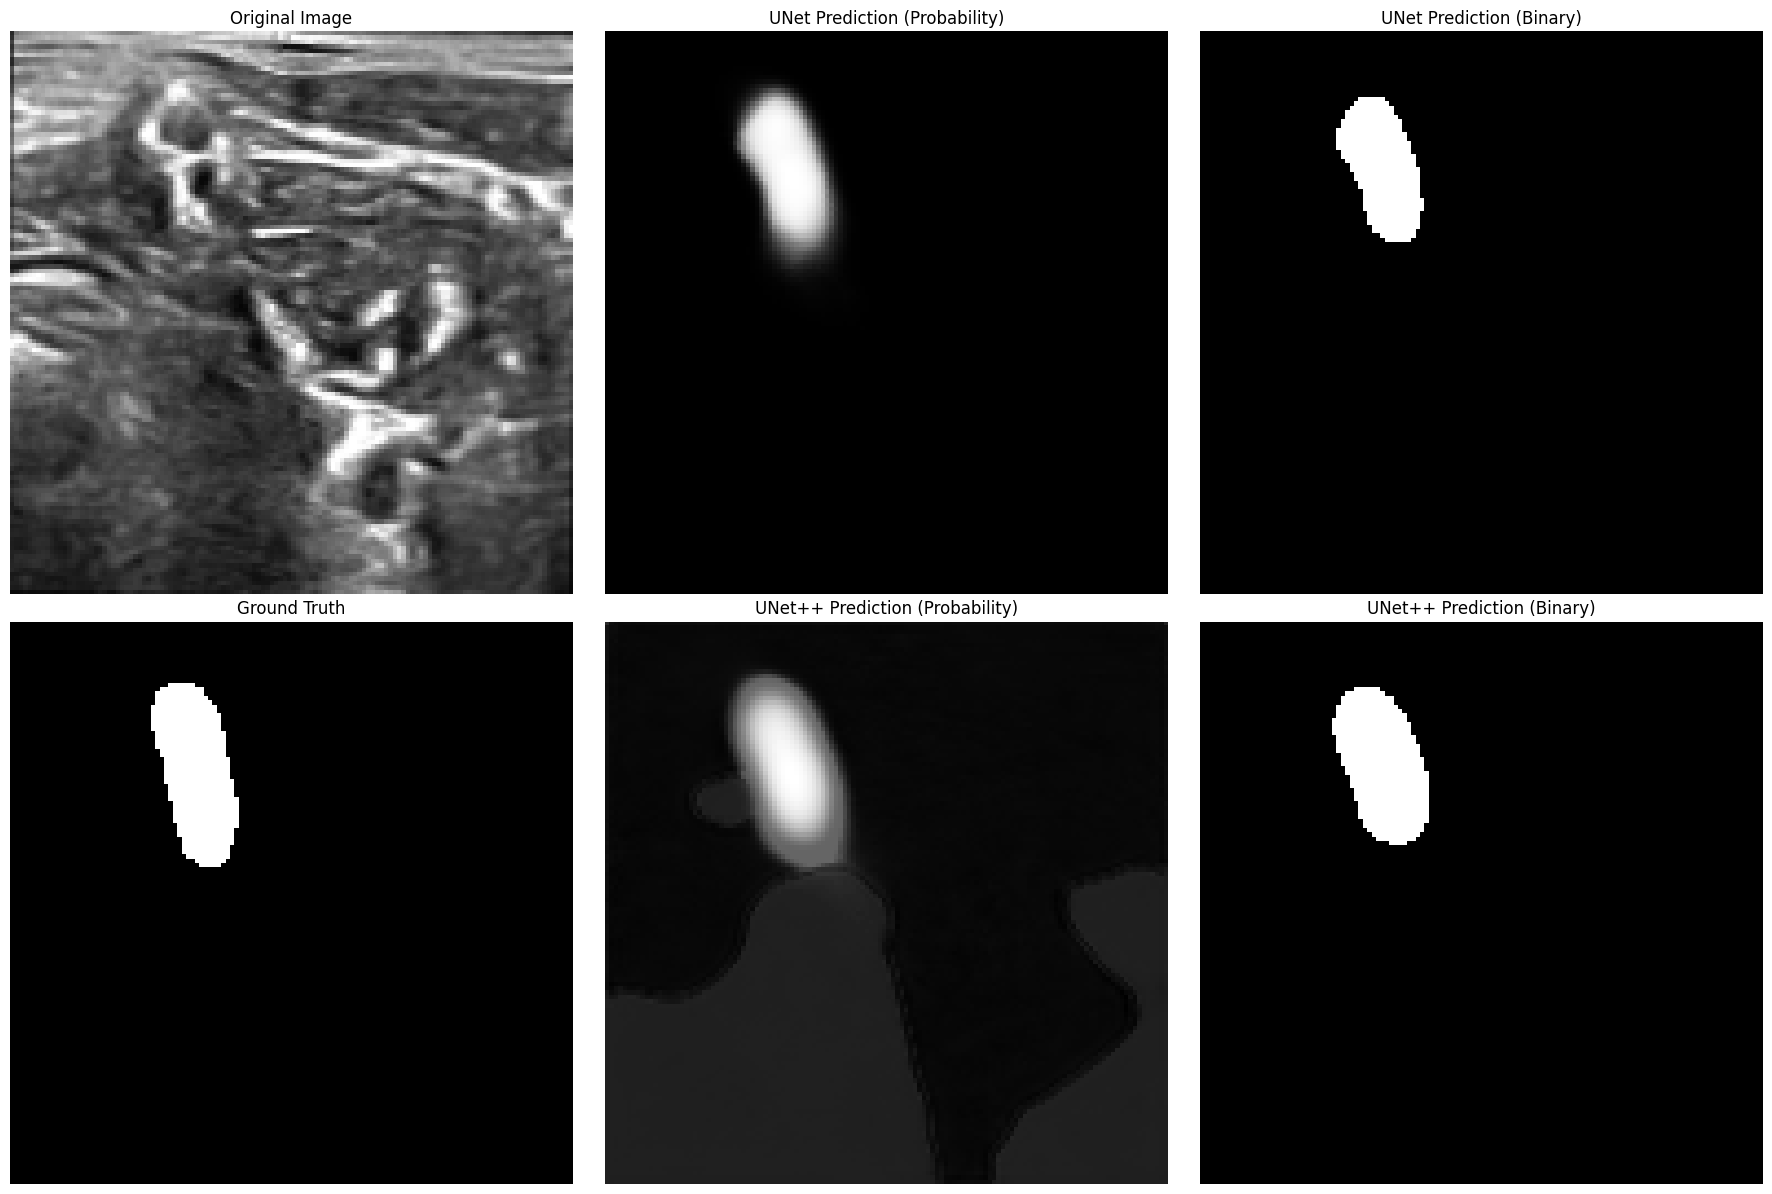

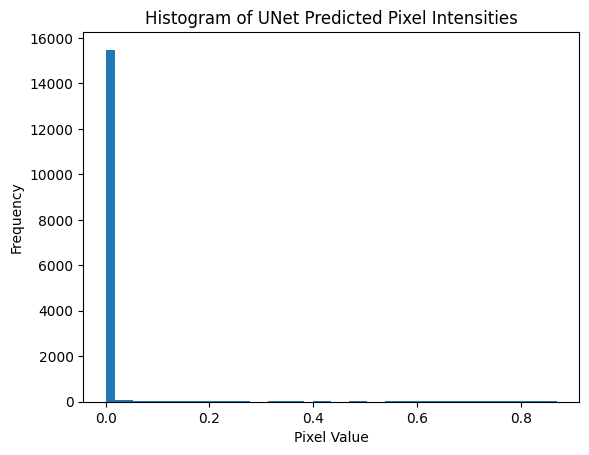

Image path not found, skipping overlay visualization

 Model comparison complete! All visualizations and metrics have been generated.
 Summary: Both UNet and UNet++ models have been successfully implemented and compared.
 Check the visualizations above for detailed performance comparison.


In [11]:
# -------------------- Fixed Evaluation and Comparison --------------------
def evaluate_model(model, model_name):
    print(f"\n{'='*30}")
    print(f"Evaluating {model_name}")
    print(f"{'='*30}")
    
    criterion = nn.BCEWithLogitsLoss()
    val_loss, dice_coef = validate(model, valid_loader, valid_data, criterion, model_name)
    
    print(f"{model_name} Results:")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Dice Coefficient: {dice_coef:.4f}")
    
    return val_loss, dice_coef

# Evaluate both models
unet_val_loss, unet_dice = evaluate_model(unet_model, "UNet")
unetpp_val_loss, unetpp_dice = evaluate_model(unetpp_model, "UNet++")

# Comparison
print(f"\n{'='*50}")
print("MODEL COMPARISON")
print(f"{'='*50}")
print(f"{'Model':<15} {'Val Loss':<12} {'Dice Score':<12}")
print("-" * 40)
print(f"{'UNet':<15} {unet_val_loss:<12.4f} {unet_dice:<12.4f}")
print(f"{'UNet++':<15} {unetpp_val_loss:<12.4f} {unetpp_dice:<12.4f}")
print("-" * 40)

if unetpp_dice > unet_dice:
    print(f" UNet++ wins by {(unetpp_dice - unet_dice):.4f} Dice score!")
else:
    print(f" UNet wins by {(unet_dice - unetpp_dice):.4f} Dice score!")


# -------------------- Visualizations --------------------
def visualize_predictions(model, model_name, sample_idx=120):
    model.eval()
    
    # Load sample for single prediction
    data = train_data[sample_idx]
    
    # Ground truth
    plt.figure(figsize=(5, 5))
    plt.imshow(data['mask'], cmap="gray")
    plt.title(f"Ground Truth - Sample {sample_idx}")
    plt.axis('off')
    plt.show()
    
    # Prediction
    img_tensor = data['image'].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(img_tensor)
        if isinstance(pred, list):
            pred = pred[-1]
        pred = pred.squeeze()
        pred = torch.sigmoid(pred)
        pred_binary = (pred > 0.5).float()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(pred_binary.detach().cpu(), cmap="gray")
    plt.title(f"{model_name} Predicted Mask - Sample {sample_idx}")
    plt.axis('off')
    plt.show()
    
    # Comparison subplot
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(data['image'].permute(1, 2, 0))
    axs[0].set_title("Original Image")
    axs[1].imshow(data['mask'], cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred.detach().cpu(), cmap='gray')
    axs[2].set_title(f"{model_name} Prediction (Continuous)")
    axs[3].imshow(pred_binary.detach().cpu(), cmap='gray')
    axs[3].set_title(f"{model_name} Prediction (Binary)")
    
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return pred, pred_binary


# -------------------- Fixed Detailed Metrics --------------------
def calculate_detailed_metrics(model, model_name):
    model.eval()
    # Initialize metric and move to device
    metric = JaccardIndex(task='binary').to(DEVICE)
    
    all_dice_scores = []
    
    with torch.no_grad():
        for _, data in tqdm(enumerate(valid_loader), desc=f"Calculating metrics for {model_name}"):
            image, mask = data["image"].to(DEVICE), data["mask"].to(DEVICE)
            outputs = model(image)
            
            if isinstance(outputs, list):
                outputs = outputs[-1]
                
            outputs = outputs.squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            for k in range(mask.shape[0]):
                # Keep tensors on GPU for metric calculation
                dice_score = metric(preds[k], mask[k].int())
                all_dice_scores.append(dice_score.item())
    
    return {
        'dice_scores': all_dice_scores,
        'mean_dice': np.mean(all_dice_scores),
        'std_dice': np.std(all_dice_scores)
    }

# Visualize UNet predictions
print("Visualizing UNet predictions...")
unet_pred, unet_pred_binary = visualize_predictions(unet_model, "UNet", 120)

# Visualize UNet++ predictions
print("Visualizing UNet++ predictions...")
unetpp_pred, unetpp_pred_binary = visualize_predictions(unetpp_model, "UNet++", 120)

# Calculate detailed metrics
print("Calculating detailed metrics...")
unet_metrics = calculate_detailed_metrics(unet_model, "UNet")
unetpp_metrics = calculate_detailed_metrics(unetpp_model, "UNet++")

print(f"\nDetailed Metrics Comparison:")
print(f"{'Model':<15} {'Mean Dice':<12} {'Std Dice':<12}")
print("-" * 40)
print(f"{'UNet':<15} {unet_metrics['mean_dice']:<12.4f} {unet_metrics['std_dice']:<12.4f}")
print(f"{'UNet++':<15} {unetpp_metrics['mean_dice']:<12.4f} {unetpp_metrics['std_dice']:<12.4f}")


# -------------------- Rest of visualizations and analysis --------------------
# Side-by-side Model Comparison
def compare_models_visualization(sample_idx=120):
    data = train_data[sample_idx]
    img_tensor = data['image'].unsqueeze(0).to(DEVICE)
    
    # Get predictions from both models
    unet_model.eval()
    unetpp_model.eval()
    
    with torch.no_grad():
        # UNet prediction
        unet_pred = unet_model(img_tensor).squeeze()
        unet_pred_prob = torch.sigmoid(unet_pred)
        unet_pred_binary = (unet_pred_prob > 0.5).float()
        
        # UNet++ prediction
        unetpp_pred = unetpp_model(img_tensor)
        if isinstance(unetpp_pred, list):
            unetpp_pred = unetpp_pred[-1]
        unetpp_pred = unetpp_pred.squeeze()
        unetpp_pred_prob = torch.sigmoid(unetpp_pred)
        unetpp_pred_binary = (unetpp_pred_prob > 0.5).float()
    
    # Create comparison plot
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: UNet
    axs[0, 0].imshow(data['image'].permute(1, 2, 0))
    axs[0, 0].set_title("Original Image")
    axs[0, 1].imshow(unet_pred_prob.detach().cpu(), cmap='gray')
    axs[0, 1].set_title("UNet Prediction (Probability)")
    axs[0, 2].imshow(unet_pred_binary.detach().cpu(), cmap='gray')
    axs[0, 2].set_title("UNet Prediction (Binary)")
    
    # Row 2: UNet++
    axs[1, 0].imshow(data['mask'], cmap='gray')
    axs[1, 0].set_title("Ground Truth")
    axs[1, 1].imshow(unetpp_pred_prob.detach().cpu(), cmap='gray')
    axs[1, 1].set_title("UNet++ Prediction (Probability)")
    axs[1, 2].imshow(unetpp_pred_binary.detach().cpu(), cmap='gray')
    axs[1, 2].set_title("UNet++ Prediction (Binary)")
    
    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Comparing both models side-by-side...")
compare_models_visualization(120)


# -------------------- Original Histogram and Overlay --------------------
# Histogram of prediction
data = train_data[120]
img_tensor = data['image'].unsqueeze(0).to(DEVICE)
with torch.no_grad():
    pred = unet_model(img_tensor).squeeze()
    pred_sigmoid = torch.sigmoid(pred)
    pred_binary = (pred_sigmoid > 0.0).float()

plt.hist(pred_sigmoid.cpu().detach().numpy().flatten(), bins=50)
plt.title("Histogram of UNet Predicted Pixel Intensities")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Overlay prediction
try:
    img_path = 'image/1_9.tif'
    if os.path.exists(img_path):
        raw_img = np.array(Image.open(img_path).convert("RGB"))
        transformed = validation_transform(image=raw_img)['image'].unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = unet_model(transformed)
            out = torch.sigmoid(out)
            out = (out > 0.5).float().squeeze().cpu().numpy()
        plt.imshow(raw_img)
        plt.imshow(out, cmap='jet', alpha=0.5)
        plt.title("Overlay: UNet Prediction on Raw Image")
        plt.axis('off')
        plt.show()
    else:
        print("Image path not found, skipping overlay visualization")
except Exception as e:
    print(f"Could not create overlay: {e}")

print("\n Model comparison complete! All visualizations and metrics have been generated.")
print(" Summary: Both UNet and UNet++ models have been successfully implemented and compared.")
print(" Check the visualizations above for detailed performance comparison.")

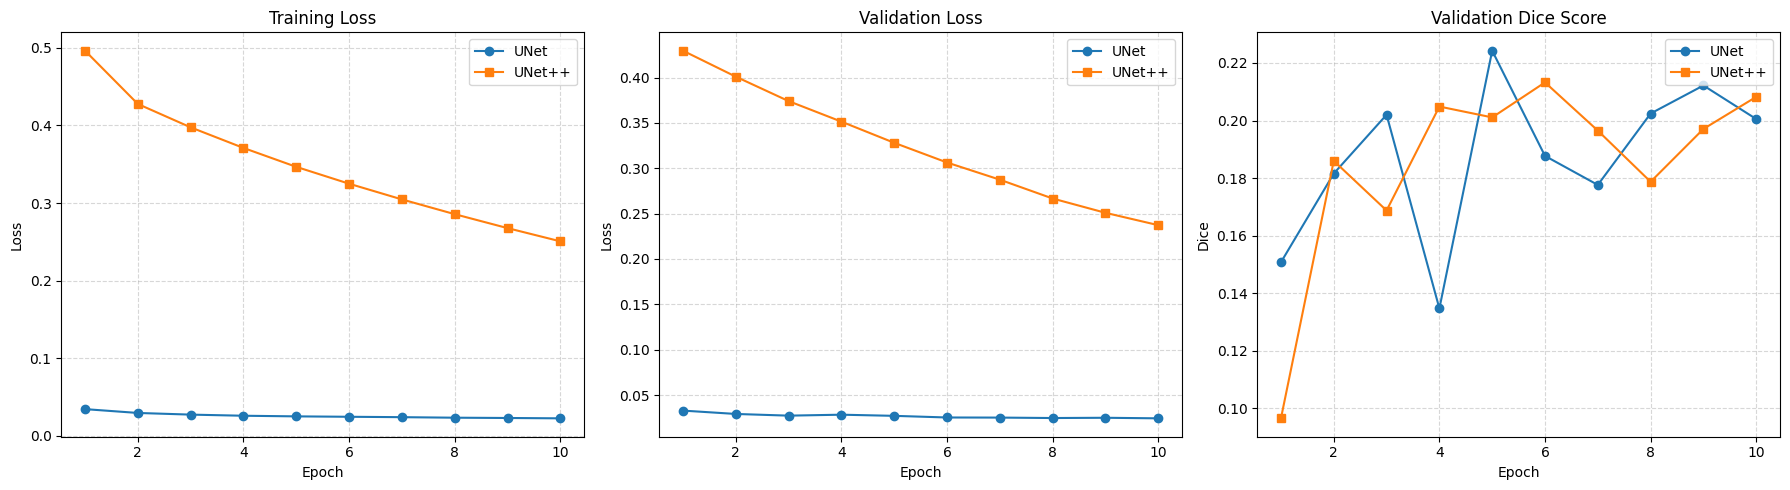

In [12]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(unet_results['train_losses']) + 1)

train_loss_unet   = unet_results['train_losses']
val_loss_unet     = unet_results['val_losses']
dice_unet         = unet_results['dice_scores']

train_loss_unetpp = unetpp_results['train_losses']
val_loss_unetpp   = unetpp_results['val_losses']
dice_unetpp       = unetpp_results['dice_scores']


plt.figure(figsize=(18, 5))

# --- 1) Training Loss ---
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_unet,   label='UNet',   marker='o')
plt.plot(epochs_range, train_loss_unetpp, label='UNet++', marker='s')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- 2) Validation Loss ---
plt.subplot(1, 3, 2)
plt.plot(epochs_range, val_loss_unet,   label='UNet',   marker='o')
plt.plot(epochs_range, val_loss_unetpp, label='UNet++', marker='s')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- 3) Validation Dice Score ---
plt.subplot(1, 3, 3)
plt.plot(epochs_range, dice_unet,   label='UNet',   marker='o')
plt.plot(epochs_range, dice_unetpp, label='UNet++', marker='s')
plt.title('Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

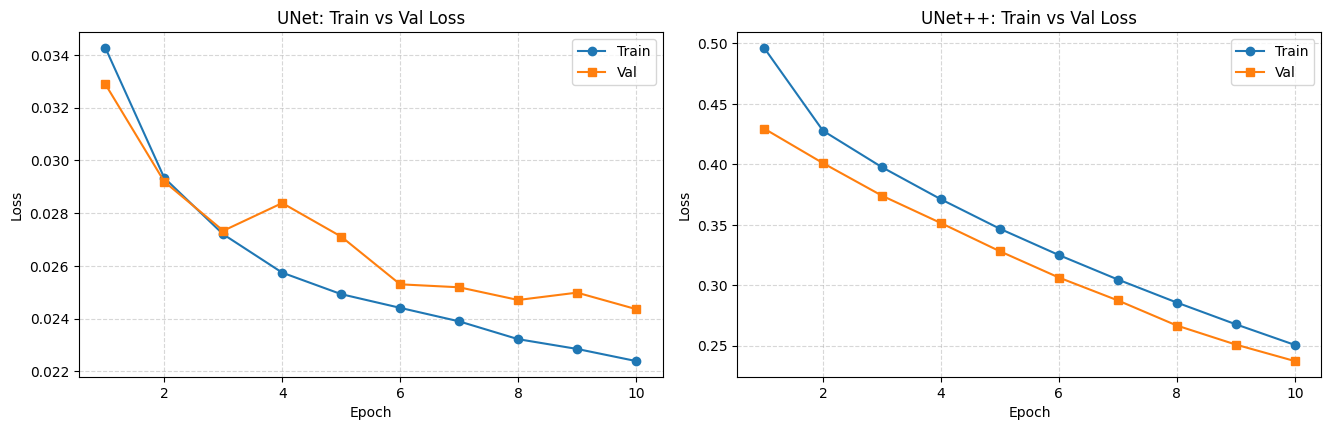

In [14]:
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Helper lists
# -------------------------------------------------
epochs_range = range(1, len(unet_results['train_losses']) + 1)

tl_unet   = unet_results['train_losses']
vl_unet   = unet_results['val_losses']
dice_unet = unet_results['dice_scores']

tl_unetpp = unetpp_results['train_losses']
vl_unetpp = unetpp_results['val_losses']
dice_unetpp = unetpp_results['dice_scores']

# -------------------------------------------------
# 2. Five sub-plots in one figure
# -------------------------------------------------
plt.figure(figsize=(20, 8))

# 4) Training vs Validation Loss (UNet only)
plt.subplot(2, 3, 4)
plt.plot(epochs_range, tl_unet, label='Train', marker='o')
plt.plot(epochs_range, vl_unet, label='Val', marker='s')
plt.title('UNet: Train vs Val Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, ls='--', alpha=.5)

# 5) Training vs Validation Loss (UNet++ only)
plt.subplot(2, 3, 5)
plt.plot(epochs_range, tl_unetpp, label='Train', marker='o')
plt.plot(epochs_range, vl_unetpp, label='Val', marker='s')
plt.title('UNet++: Train vs Val Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, ls='--', alpha=.5)

plt.tight_layout()
plt.show()